# Setup

**Imports**

In [1]:
!pip install ruptures
!pip install contextily
!pip install pygsp
!pip install loadmydata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for loadmydata: filename=loadmydata-0.0.11-py3-none-any.whl size=18022 sha256=83a51284022235ec76fe2ab96583be987b69574bb40cb628f6fe43c631130fd5
  Stored in directory: /root/.cache/pip/wheels/43/16/85/7c6a4152d2b99f1e83db216f6a0e8116700f0f03cc555f2c7c
Successfully built loadmydata


In [12]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

rng = np.random.default_rng()

import re
from math import asin, cos, radians, sin, sqrt

from matplotlib.dates import DayLocator, DateFormatter
import pandas as pd
import contextily as cx
import geopandas
from pygsp import graphs
import networkx as nx
import seaborn as sns
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.spatial.distance import pdist, squareform
from collections import Counter
import matplotlib.colors as mcolors

import scipy
from scipy.linalg import eig, eigh
import scipy.signal as sp
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D,Dropout, LeakyReLU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

from tqdm import tqdm
import time


**Utility functions**

In [3]:
def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [4]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [5]:
def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [6]:
def is_connected(graph):
    return graph.is_connected(recompute=True)

In [7]:
def energy(x):
  return sum(np.abs(x)**2)

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences.

The signals have a varying number of symbols with a varying duration.
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [9]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()


In [10]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


In [13]:
# Lmaximal length of the sequences
max_len = max(len(seq) for seq in X_train)

# Trainingdata preporcessing and labels encoding
X_train_padded = pad_sequences(X_train, padding='post', dtype='float32', maxlen=max_len)
X_train_reshaped = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)

y_train_flat = np.concatenate(y_train)
label_encoder = LabelEncoder()
label_encoder.fit(y_train_flat)
y_train_encoded = label_encoder.transform(y_train_flat)
label_encoder.classes_ = np.sort(label_encoder.classes_)# Tri des classes


# CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_len, 1)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=len(set(y_train_encoded)), activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model training
model.fit(X_train_reshaped, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)

# Prediction on the training dataset
predictions = model.predict(X_train_reshaped)
predicted_labels = np.argmax(predictions, axis=1) #classes
predicted_symbols = label_encoder.inverse_transform(predicted_labels)#classes to symboles

# Compaision with the real training symbols
start_idx = 0
for i in range(len(X_train)):
    end_idx = start_idx + len(y_train[i])
    predicted_symbols_i = predicted_symbols[start_idx:end_idx]
    print(f"Signal {i+1} - Réels: {' '.join(y_train[i])} - Prédits: {' '.join(predicted_symbols_i)}")
    start_idx = end_idx


Epoch 1/20
3/3 [==============================] - 5s 385ms/step - loss: 188.5172 - accuracy: 0.0375 - val_loss: 257.5836 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 0s 130ms/step - loss: 143.5880 - accuracy: 0.3750 - val_loss: 286.0005 - val_accuracy: 0.2000
Epoch 3/20
3/3 [==============================] - 0s 131ms/step - loss: 138.4769 - accuracy: 0.4250 - val_loss: 230.0220 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 0s 131ms/step - loss: 89.3416 - accuracy: 0.5750 - val_loss: 231.8924 - val_accuracy: 0.0500
Epoch 5/20
3/3 [==============================] - 0s 133ms/step - loss: 25.2738 - accuracy: 0.7625 - val_loss: 165.3485 - val_accuracy: 0.0500
Epoch 6/20
3/3 [==============================] - 0s 132ms/step - loss: 4.1696 - accuracy: 0.9375 - val_loss: 230.5287 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 0s 131ms/step - loss: 3.5578 - accuracy: 0.9000 - val_loss: 248.3884 - val_acc

# Question 2

In [14]:
# Testing dataset
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [15]:
# Preprocessing of the testing dataset
X_test_padded = pad_sequences(X_test, padding='post', dtype='float32', maxlen=max_len)
X_test_reshaped = X_test_padded.reshape(X_test_padded.shape[0], X_test_padded.shape[1], 1)

for i,signal in enumerate(X_test):
    #We calculate the maximal frequence of the signal to have the optimal npsreg
    fft_result = fft(signal)
    frequencies = np.fft.fftfreq(len(fft_result), 1/FS)
    positive_frequencies = frequencies[:len(frequencies)//2]
    max_frequency_index = np.argmax(np.abs(fft_result[:len(frequencies)//2]))
    max_expected_frequency = positive_frequencies[max_frequency_index]
    nperseg = min(256, int(len(signal) / (max_expected_frequency / 2)))
    print(nperseg)

    # Algoithm of "change-point detection"
    f, t, Zxx = sp.stft(signal, fs=FS, nperseg=nperseg)
    pdgram = np.abs(np.square(Zxx))
    algo = rpt.Dynp(model='l2', jump=1).fit(pdgram.T)
    predicted_bkps = algo.predict(n_bkps=len(y_test[i])//2)

    #We divide each signal into segments beforre predicting with the trained model
    segments = np.split(signal, predicted_bkps)
    segments_padded = pad_sequences(segments, padding='post', dtype='float32', maxlen=max_len)
    segments_reshaped = segments_padded.reshape(segments_padded.shape[0], segments_padded.shape[1], 1)

    predictions = model.predict(segments_reshaped)
    predicted_classes = np.argmax(predictions, axis=1) # Retrieving the predicted class for each segment
    predicted_symbols = label_encoder.inverse_transform(predicted_classes) #classes to symbols

    # Decoded signal
    decoded_sequence = " ".join(predicted_symbols)
    true_sequence=" ".join(y_test[i])
    print(f"Signal-{i+1}: Reel:{true_sequence} - Predicted: {decoded_sequence}")

69
1/1 [==============================] - 0s 82ms/step
Signal-1: Reel:7 2 1 C 9 9 - Predicted: 0 * 4 4 8
39
1/1 [==============================] - 0s 20ms/step
Signal-2: Reel:1 # 2 # - Predicted: * 5 * 8


# Question 3

In [16]:
# Functions to compute the kernel of Spectrum Adapted Graph Wavelets (SAGW)

def hat_g_m(lambd, R, m, lambd_n = 12, M = 9):
  a = lambd_n / (M + 1 - R)
  return hat_g_U(lambd - a*m, R, a, M = 9)

def hat_g_U(lambd, R, a, M = 9):
  return  0.5 * (1 + np.cos(2*np.pi*(lambd/(a*R) + 0.5)))*(lambd < 0)*(lambd >= -R*a)

def plot_kernel_function(R, lambd_n=12, M=9):
    lmbda_values = np.linspace(0,lambd_n,1000)
    a=(lambd_n)/(M+1-R)
    for m in np.arange(1,M+1):
      plt.plot(lmbda_values, hat_g_m(lmbda_values,R,m,lambd_n),label=f'm={m}')
    plt.title(f'Spectrum Adapted Graph Wavelet Kernel for R={R}')
    plt.xlabel('Eigenvalue ($\lambda$)')
    plt.ylabel('$\hat{g}_m$')
    plt.legend()
    plt.grid(True)
    plt.show()

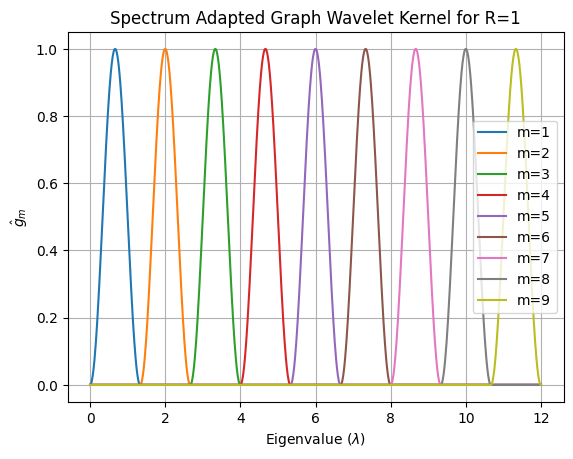

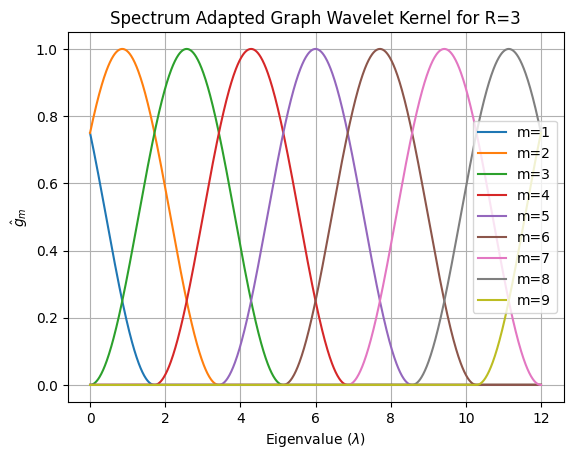

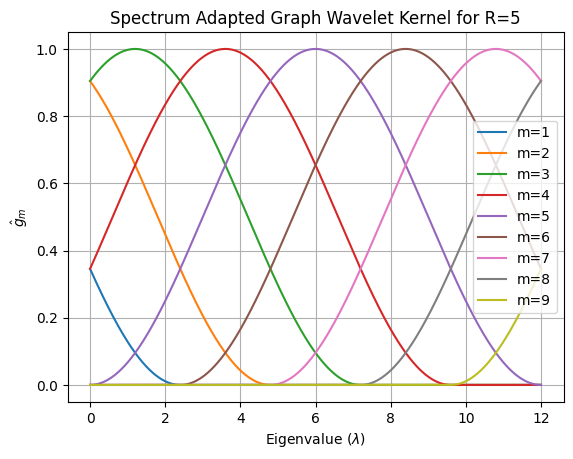

In [17]:
M = 9
lambdn = 12
plot_kernel_function(1)
plot_kernel_function(3)
plot_kernel_function(5)

# Question 4

We load the datasets

In [18]:
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

100%|██████████| 1.14M/1.14M [00:03<00:00, 344kiB/s]
100%|██████████| 5.06k/5.06k [00:00<00:00, 2.19MiB/s]


The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [19]:
stations_df.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131


In [20]:
# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15

In [21]:
data_df[data_df["temp"].isna()]["station_name"].value_counts()

CAMARET               744
BATZ                  744
BEG_MEIL              744
PLOUGONVELIN          717
VANNES-MEUCON          39
ST NAZAIRE-MONTOIR      3
PLOUDALMEZEAU           2
SIZUN                   1
Name: station_name, dtype: int64


Pivot the table. We now have a multivariate time serie.

In [22]:
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-31 19:00:00,10.2,11.7,NaN,NaN,11.3,10.5,11.0,11.9,NaN,9.2,...,11.5,11.0,10.9,9.6,9.8,11.6,10.2,11.4,10.3,10.6
2014-01-31 20:00:00,11.0,11.7,NaN,NaN,11.2,10.9,10.8,11.7,NaN,9.5,...,11.2,10.7,11.0,10.6,10.5,11.5,10.9,11.4,10.5,11.0
2014-01-31 21:00:00,11.1,11.8,NaN,NaN,11.4,11.0,10.7,11.4,NaN,9.9,...,10.9,10.6,10.8,10.9,10.6,11.2,10.9,11.5,10.6,11.0


Display all stations with missing values in the temperature, then remove them.

In [23]:
temperature_df.isna().sum(axis=0).sort_values(ascending=False)

station_name
BATZ                   744
BEG_MEIL               744
CAMARET                744
PLOUGONVELIN           744
RIEC SUR BELON         144
ST NAZAIRE-MONTOIR      70
PLOUAY-SA               63
VANNES-MEUCON           50
LANNAERO                37
PLOUDALMEZEAU            2
LANDIVISIAU              1
SIZUN                    1
QUIMPER                  1
OUESSANT-STIFF           1
LANVEOC                  1
ARZAL                    1
BREST-GUIPAVAS           1
BRIGNOGAN                1
SIBIRIL S A              0
DINARD                   0
QUINTENIC                0
ROSTRENEN                0
SAINT-CAST-LE-G          0
SAINT-JOACHIM_SAE        0
SARZEAU SA               0
KERPERT                  0
PTE DE PENMARCH          0
SPEZET                   0
ST BRIEUC                0
BIGNAN                   0
ST-SEGAL S A             0
THEIX                    0
TREGUNC                  0
BELLE ILE-LE TALUT       0
PTE DU RAZ               0
PTE DE CHEMOULIN         0
ILE-DE-BREHAT  

In [24]:
station_name_NaNs = temperature_df.columns[temperature_df.isna().any()].tolist()
station_name_NaNs

['ARZAL',
 'BATZ',
 'BEG_MEIL',
 'BREST-GUIPAVAS',
 'BRIGNOGAN',
 'CAMARET',
 'LANDIVISIAU',
 'LANNAERO',
 'LANVEOC',
 'OUESSANT-STIFF',
 'PLOUAY-SA',
 'PLOUDALMEZEAU',
 'PLOUGONVELIN',
 'QUIMPER',
 'RIEC SUR BELON',
 'SIZUN',
 'ST NAZAIRE-MONTOIR',
 'VANNES-MEUCON']

In [25]:
# Remove all stations with missing values for temperature.
temperature_df = temperature_df.dropna(axis=1, how="any")
cond = stations_df.Nom.isin(station_name_NaNs)
stations_df = stations_df[~cond]
cond = data_df.station_name.isin(station_name_NaNs)
data_df = data_df[~cond].reset_index().drop("index", axis="columns")

Display the distance matrix

In [26]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed) # convertir format de matrice de distance "condensé" vers format "carré" (matriciel).

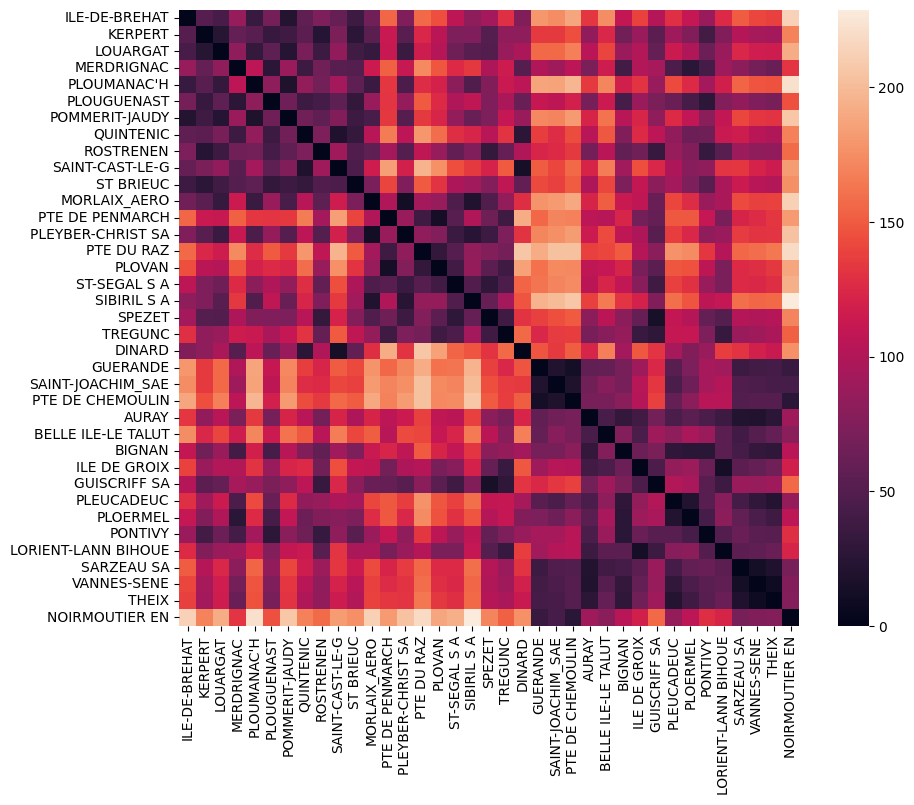

In [27]:
fig, ax = fig_ax((10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=stations_df.Nom,
    yticklabels=stations_df.Nom,
    ax=ax,
)

Choose the minimum threshold so that the network is connected and the average degree is at least 3

In [28]:
sigma = np.median(dist_mat_condensed)
def threshold_determine(thresholds):
    i = 0
    th = thresholds[-1]
      # median heuristic
    adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, th)
    )
    G = graphs.Graph(adjacency_matrix_gaussian)
    while not(is_connected(G)) or G.d.mean()< 3:
        i -= 1
        th = thresholds[i]
        adjacency_matrix_gaussian = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, th)
        )
        G = graphs.Graph(adjacency_matrix_gaussian)

    return th,G

thresholds = np.linspace(0,1,2000)
th,G_gaussian = threshold_determine(thresholds)
print("Minimal threshold:", th)
print(
    f"The graph is {'not ' if not is_connected(G_gaussian) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges"
)

Minimal threshold: 0.8319159579789894
The graph is connected, with 37 nodes, 75 edges


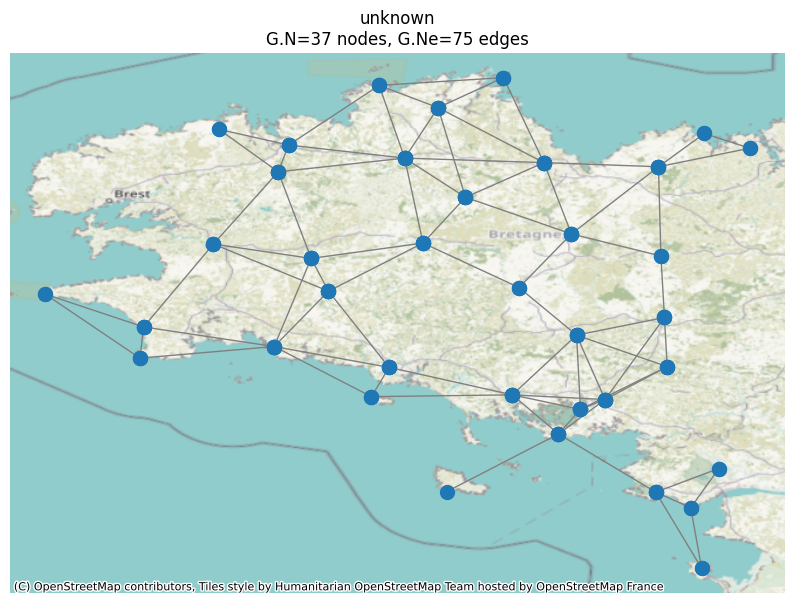

In [29]:
# Plot the graph associated to this threshold
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(stations_df.Longitude, stations_df.Latitude),
).set_crs("EPSG:4326")
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot(ax=ax)

Smoothness plot

In [30]:
# Choose a specific hour and calculate smoothness
choosen_hour = pd.to_datetime("2014-01-01 01:00:00")

laplacian_matrix = G_gaussian.L.todense()

signal = temperature_df.loc[choosen_hour].to_numpy()

smoothness = float(signal.T.dot(laplacian_matrix).dot(signal))
print(f"Smoothness is {smoothness:.2f} ({choosen_hour})")

Smoothness is 359.89 (2014-01-01 01:00:00)


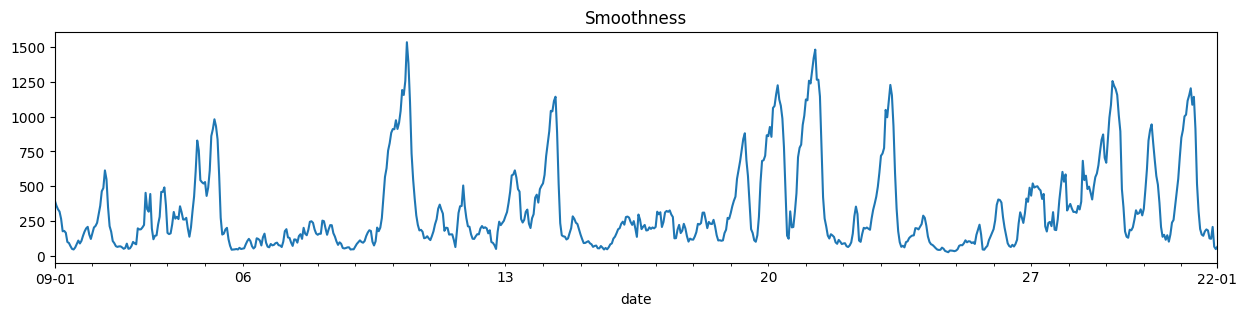

In [31]:
# Plot the smoothness
signals = temperature_df.to_numpy()
smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df.index
)

fig, ax = fig_ax()
smoothness_df.plot(ax=ax)
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")
plt.show()

In [32]:
# Find the date with smallest value
date_min_value = smoothness_df.idxmin()
min_value = smoothness_df.min()

# Find the date with largest value
date_max_value = smoothness_df.idxmax()
max_value = smoothness_df.max()

print(f"Smoothest: Time {date_min_value}, Value {min_value}")
print(f"Least smooth: Time {date_max_value}, Value {max_value}")

Smoothest: Time 2014-01-24 19:00:00, Value 24.394985986073582
Least smooth: Time 2014-01-10 09:00:00, Value 1536.0127016772685


# Question 5

Wavelet transform for graph signals

In [33]:
def GFT(x,dist_mat_condensed):
    '''
    Computes the Graph Fourrier Transform of x, the eigenvalues and eigenvectors of L

    x: an array (the signal)
    dist_mat_condensed: the distance matrix in dense form
    '''
    sigma = np.median(dist_mat_condensed)
    adjacency_matrix_gaussian = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, th)
        )
    G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
    laplacian_matrix = G_gaussian.L.todense()
    eigvals, eigvecs = eigh(laplacian_matrix)
    eigvals = np.real(eigvals)

    # Sort
    idx = eigvals.argsort()
    eigvals = eigvals[idx]
    U = eigvecs[:,idx]

    return U.T @ x, eigvals, eigvecs


def W_f(f, m, v, f_hat, eigvals, eigvecs, R=3, M=9):
    '''
    Computes the Graph Wavelet Transform of f

    f: the function
    m: scale in {1,...,M}
    v: a node

    Returns a scalar
    '''

    g_m_values = hat_g_m(eigvals, R, m, lambd_n=eigvals[-1])

    return np.sum(g_m_values * f_hat * eigvecs[v, :])

Perform classification

In [34]:
# Time associated to largest value (least smooth)
time_max_smooth = temperature_df.index[np.argmax(smoothness_arr)]
f_max_smooth = temperature_df.loc[time_max_smooth] # Contains the temperatures at time time_max_smooth for the 37 cities.

# Time associated to smallest value (smoothest)
time_min_smooth = temperature_df.index[np.argmin(smoothness_arr)]
f_min_smooth = temperature_df.loc[time_min_smooth] # Contains the temperatures at time time_min_smooth for the 37 cities.

# Time associated to first timestamp
time_first = temperature_df.index[0]
f_first = temperature_df.loc[time_first] # Contains the temperatures at time time_first for the 37 cities.

In [35]:
def labels_nodes(f, dist_mat_condensed, m_list, v_list):
    '''
    f: a signal associated to a given time
    dist_mat_condensed: the distance matrix in dense form
    m_list: list of scales
    v_list: list of nodes

    Returns an array containing the labels of each node
    '''
    labels = []
    f_hat,eigvals,eigvecs = GFT(f,dist_mat_condensed)
    for v in v_list:
      W_v = []
      for m in m_list:
        W_v.append(W_f(f,m,v,f_hat,eigvals,eigvecs))

      # For each node, we keep the scales contaning most of the energy.
      labels.append(np.argmax([energy(W_v[:3]),energy(W_v[3:6]),energy(W_v[6:])]))


    return labels


In [36]:
M = 9
R = 3

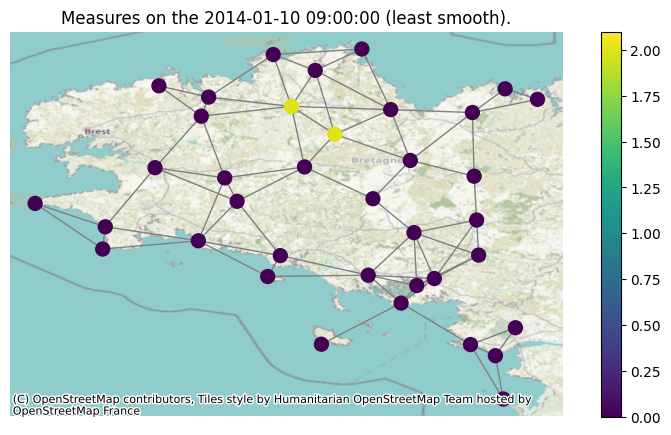

In [37]:
m_list = np.arange(1,M+1)
v_list = range(len(f_max_smooth))
labels = labels_nodes(f_max_smooth,dist_mat_condensed,m_list,v_list)


ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(labels), ax=ax)
_ = ax.set_title(f"Measures on the {time_max_smooth} (least smooth).")

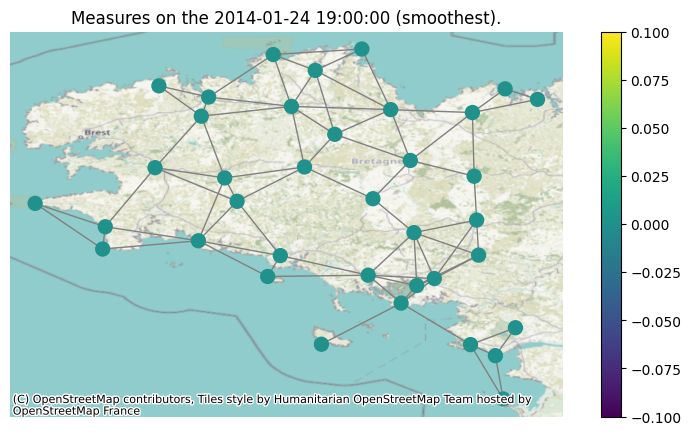

In [38]:
m_list = np.arange(1,M+1)
v_list = range(len(f_min_smooth))
labels = labels_nodes(f_min_smooth,dist_mat_condensed,m_list,v_list)


ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(labels), ax=ax)
_ = ax.set_title(f"Measures on the {time_min_smooth} (smoothest).")

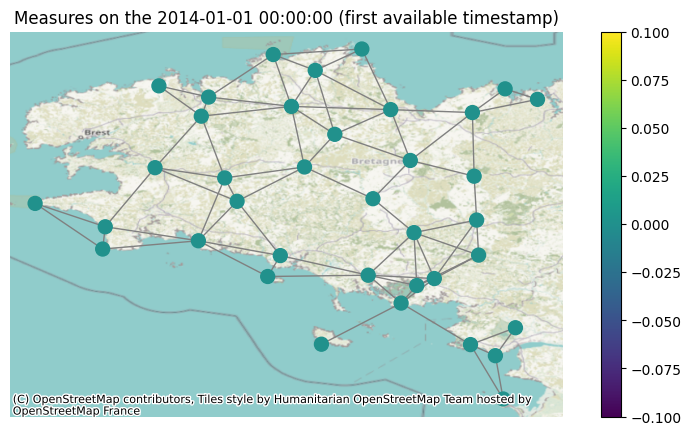

In [39]:
m_list = np.arange(1,M+1)
v_list = range(len(f_first))
labels = labels_nodes(f_first,dist_mat_condensed,m_list,v_list)


ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(labels), ax=ax)
_ = ax.set_title(f"Measures on the {time_first} (first available timestamp)")

# Question 6

Display the average temperature and for each timestamp, adapt the marker colour to the majority class present in the graph.

In [40]:
timestamps = temperature_df.index
most_common_label_list = []
mean_temps_list = []
for time in tqdm(timestamps):
   temps = temperature_df.loc[time]
   labels = labels_nodes(temps,dist_mat_condensed,m_list,v_list)
   most_common_label = Counter(labels).most_common(1)[0][0]
   mean_temps = temps.to_numpy().mean()
   most_common_label_list.append(most_common_label)
   mean_temps_list.append(mean_temps)



100%|██████████| 744/744 [00:15<00:00, 48.89it/s]


<ipython-input-41-f1422a3037c8>:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=[0, 1, 2])


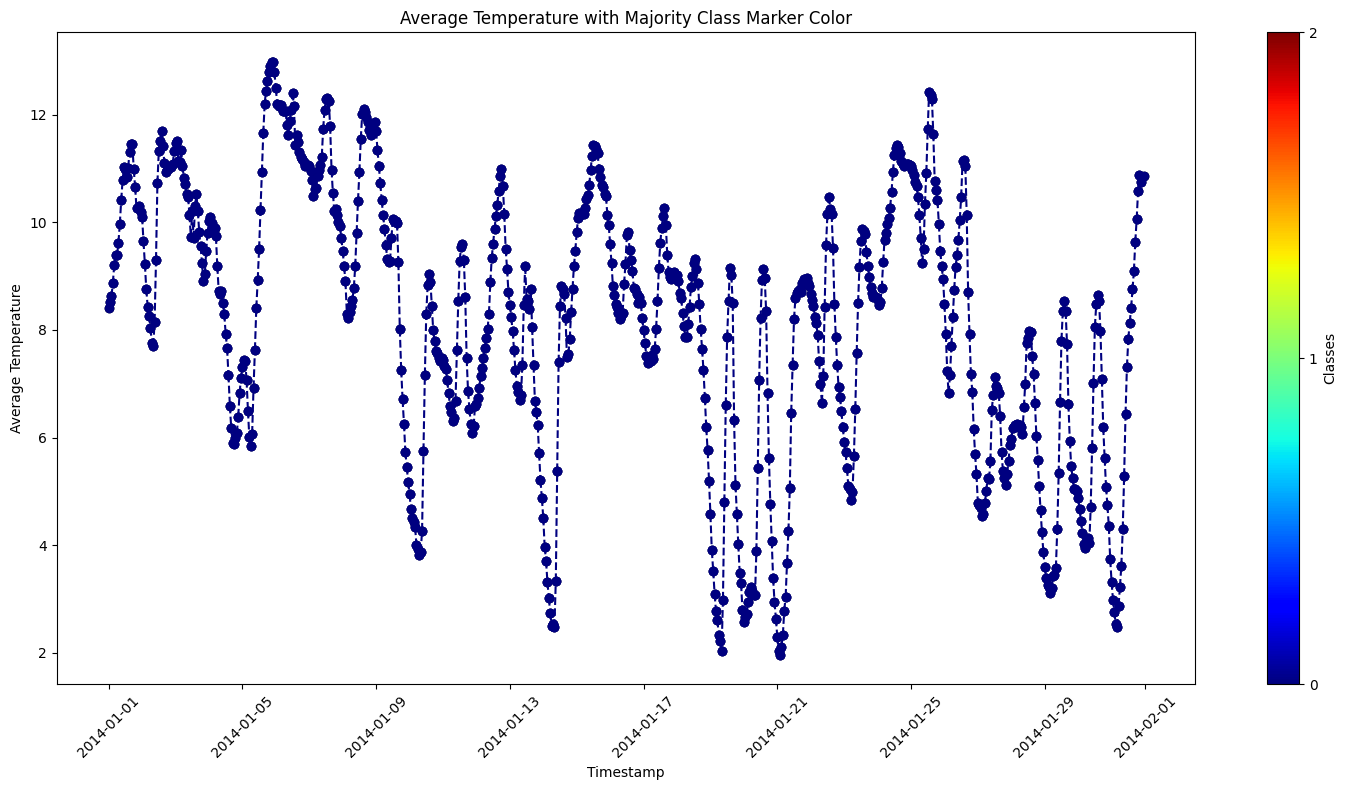

In [41]:
classes = [0, 1, 2]
colors = plt.cm.jet(classes)
class_to_color = dict(zip(classes, colors))

plt.figure(figsize=(15, 8))
plt.scatter(timestamps, mean_temps_list, color='black')

for i in range(1, len(timestamps)):
    plt.plot(timestamps[i-1:i+1], mean_temps_list[i-1:i+1],
             color=class_to_color[most_common_label_list[i-1]], linestyle='dashed', marker='o')

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=2))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=[0, 1, 2])
cbar.set_label('Classes')


plt.title("Average Temperature with Majority Class Marker Color")
plt.xlabel("Timestamp")
plt.ylabel("Average Temperature")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Question 7

Wavelet transform for graph signals, with spatio-temporal information.

In [42]:
def GFT_ST(x,timestamps,dist_mat_condensed):
    '''
    Computes the Graph Fourrier Transform, the eigenvalues and eigenvectors of L
    '''
    sigma = np.median(dist_mat_condensed)
    adjacency_matrix_gaussian = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, th)
        )
    adjacency_matrix_time = np.diag(np.ones(len(timestamps) - 1), k=1) + np.diag(np.ones(len(timestamps) - 1), k=-1)

    G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
    G_time = graphs.Graph(adjacency_matrix_time)
    L_G_gaussian = G_gaussian.L.todense()
    L_G_time = G_time.L.todense()

    eigvals_lambda, eigvecs_x = eigh(L_G_gaussian)
    eigvals_mu, eigvecs_y = eigh(L_G_time)
    eigvals_lambda,eigvals_mu = np.real(eigvals_lambda),np.real(eigvals_mu)
    n,m = L_G_gaussian.shape[0],L_G_time.shape[0]
    eigvals_H = np.zeros(n*m)

    # We use Answer 7
    for i in range(m) :
      for j in range(n) :
        eigvals_H[n*i+j] = eigvals_mu[i] + eigvals_lambda[j]

    eigvecs_H = np.zeros((n*m,n*m))
    for i in range(m) :
      for j in range(n) :
        eigvecs_H[:,n*i+j] = np.kron(eigvecs_x[:,j],eigvecs_y[:,i])

    # Sort
    idx = eigvals_H.argsort()
    eigvals_H = eigvals_H[idx]
    U = eigvecs_H[:,idx]

    return U.T @ x, eigvals_H, eigvecs_H

In [43]:
def labels_nodes_ST(f, timestamps, dist_mat_condensed, m_list, v_list):
    labels = []
    f_hat,eigvals,eigvecs = GFT_ST(f,timestamps,dist_mat_condensed)
    for v in v_list:
      W_v = []
      for m in m_list:
        W_v.append(W_f(f,m,v,f_hat,eigvals,eigvecs))

      # For each node, we keep the scales contaning most of the energy.
      labels.append(np.argmax([energy(W_v[:3]),energy(W_v[3:6]),energy(W_v[6:])]))

    return np.reshape(np.array(labels),temperature_df.shape)

Display the average temperature and for each timestamp, adapt the marker colour to the majority class present in the graph.

In [44]:
temps = np.ravel(temperature_df.to_numpy(), order='F') # Applatir en alignant les colonnes
timestamps = temperature_df.index
m_list = np.arange(1,M+1)
v_list = tqdm(range(len(temps)))
labels = labels_nodes_ST(temps,timestamps,dist_mat_condensed,m_list,v_list) # (744, 37) = (T,N_stations)

100%|██████████| 27528/27528 [03:28<00:00, 131.82it/s]


In [45]:
most_common_label_list = []
mean_temps_list = temperature_df.mean(axis=1)

for label_list in labels:
   most_common_label = Counter(label_list).most_common(1)[0][0]
   most_common_label_list.append(most_common_label)

<ipython-input-46-83876bfa1147>:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=[0, 1, 2])


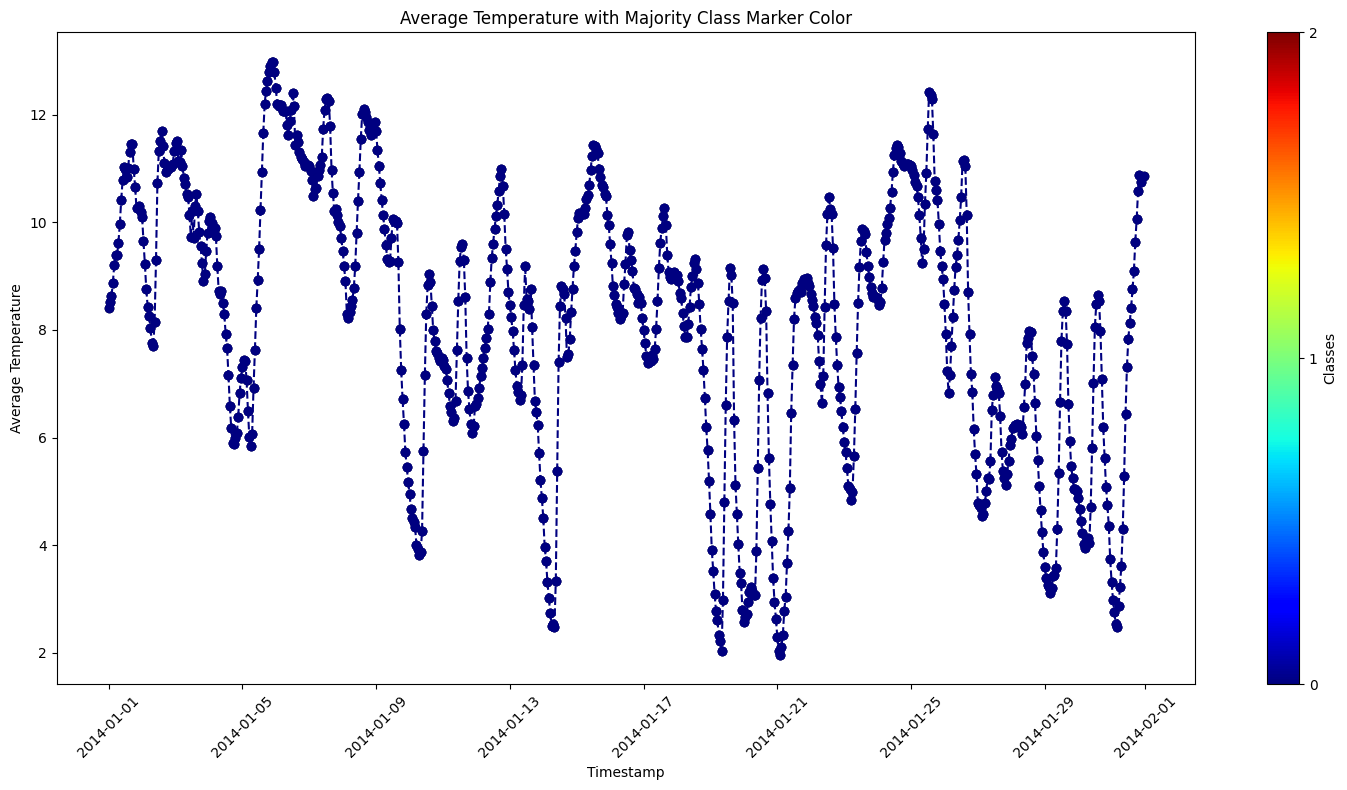

In [46]:
classes = [0, 1, 2]
colors = plt.cm.jet(classes)
class_to_color = dict(zip(classes, colors))

plt.figure(figsize=(15, 8))
plt.scatter(timestamps, mean_temps_list, color='black')

for i in range(1, len(timestamps)):
    plt.plot(timestamps[i-1:i+1], mean_temps_list[i-1:i+1],
             color=class_to_color[most_common_label_list[i-1]], linestyle='dashed', marker='o')

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=2))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=[0, 1, 2])
cbar.set_label('Classes')

plt.title("Average Temperature with Majority Class Marker Color")
plt.xlabel("Timestamp")
plt.ylabel("Average Temperature")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()